## This notebook compares beached volume values from the .sro file and the .netcdf using:
1. Surface values from `Thickness_2D` with land point extracting using locations where a beaching time exists, and
2. `Beaching_Volume`

I also plotted up values from `OilWaterColumnOilVol_3D` to see if these values exist on land points, similar to `Thickness_2D`.  

#### The take-aways from the 3-panel graphic at [8] are:
- `Beached_Volume` from the netcdf output gives the best estimate of the .sro values for `VolOilBeached` (as expected)
- `OilWaterColumnOilVol_3D` does not include land points
- `Thickness_2D` does include land points (not new information)
- I used beaching time scale to select beached values for both 3D and 2D values.  In theory, the locations ought to match, but they don't. The difference here must be in the values of Thickness_2D vs. Vol_3d.  This brings up the issue of whether Thickness_2D is the best proxy of surface oiling.  If  Vol_3d is a better estimate then this difference in the locations of values/no-values suggests that we ought to use the surface level of `OilWaterColumnOilVol_3D` to estimate surface oiling. 

In [1]:
import sys
sys.path.insert(1, '/Users/rmueller/Projects/MIDOSS/analysis-rachael/scripts/')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import xarray as xr

from midoss_utils import *
import cmocean as cm
from salishsea_tools import viz_tools
from salishsea_tools import geo_tools as gt 

# set figure fontsizes
fs=24 
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs+4)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
%matplotlib inline

## load model output

In [2]:
# netcdf
volume = 70000
fname = f'/Users/rmueller/Projects/MIDOSS/results/volume_test/Lagrangian_out_{volume}_updated.nc'
start_time = np.datetime64('2015-06-05T00:30:00')
results = {}
results = xr.open_dataset(fname)
# sro
sro_file = f'/Users/rmueller/Projects/MIDOSS/results/volume_test/resOilOutput_{volume}.sro'
sro_results = load_sro(sro_file,['VolOilBeached', 'VolumeBeached', 'VolumeOil', 'Volume'])

/Users/rmueller/Projects/MIDOSS/analysis-rachael/scripts/midoss_utils.py:37: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  pandas.datetime(numpy.int(YY), numpy.int(MM), numpy.int(DD),
/Users/rmueller/Projects/MIDOSS/analysis-rachael/scripts/midoss_utils.py:65: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  pandas.datetime(numpy.int(YY), numpy.int(MM), numpy.int(DD),


## extract beaching volume information from netcdf

In [3]:
beachingvolume ={}

#### values from `Thickness_2D`

In [4]:
# calculate beaching volume from 2D thickness
beachingtime    = results.Beaching_Time[:]
# get array size to use for converting time into numeric values
[ny,nx] = beachingtime.shape
x_range = range(nx)
y_range = range(ny)
# convert beaching time to numeric value
display('Calculating beaching time')
beachingtime_asnum = np.array([[((np.datetime64(beachingtime.values[jj,ii]) - start_time) / np.timedelta64(1, 'D')) for ii in x_range] for jj in y_range])
# set locations of absent a beaching timescale to zero
beachingtime_asnum[beachingtime_asnum==0] = np.nan
# create a logical array of true "keepers" where beaching time scale is non-zero
keepers   = np.isreal(beachingtime_asnum)
# similarly, a logical array of wasteland garbage where beaching time scale is absent 
notkeepers = np.isnan(beachingtime_asnum)
[nt,ny,nx] = results.Thickness_2D.shape

'Calculating beaching time'

In [5]:
beachingvolume['thickness'] = 500 * 440 * results.Thickness_2D[nt-1,:,:].where(keepers).values * 1e-6
beachingvolume['thickness'][beachingvolume['thickness']==0] = np.nan

#### values from `Beaching_Volume`

In [6]:
beachingvolume['beaching_volume'] = results.Beaching_Volume

#### values from `OilWaterColumnOilVol_3D`

In [7]:
beachingvolume['vol_3D'] = results['OilWaterColumnOilVol_3D'][nt-1,39,:,:].where(keepers).values

## Plot comparison

<ipython-input-8-3dec32fc3ecf>:14: RuntimeWarning: divide by zero encountered in log10
  np.log10(beachingvolume[plot_vars[i-1]]),
/Users/rmueller/opt/miniconda3/envs/standard/lib/python3.9/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


Text(0.5, 1.0, 'Beached_Volume values')

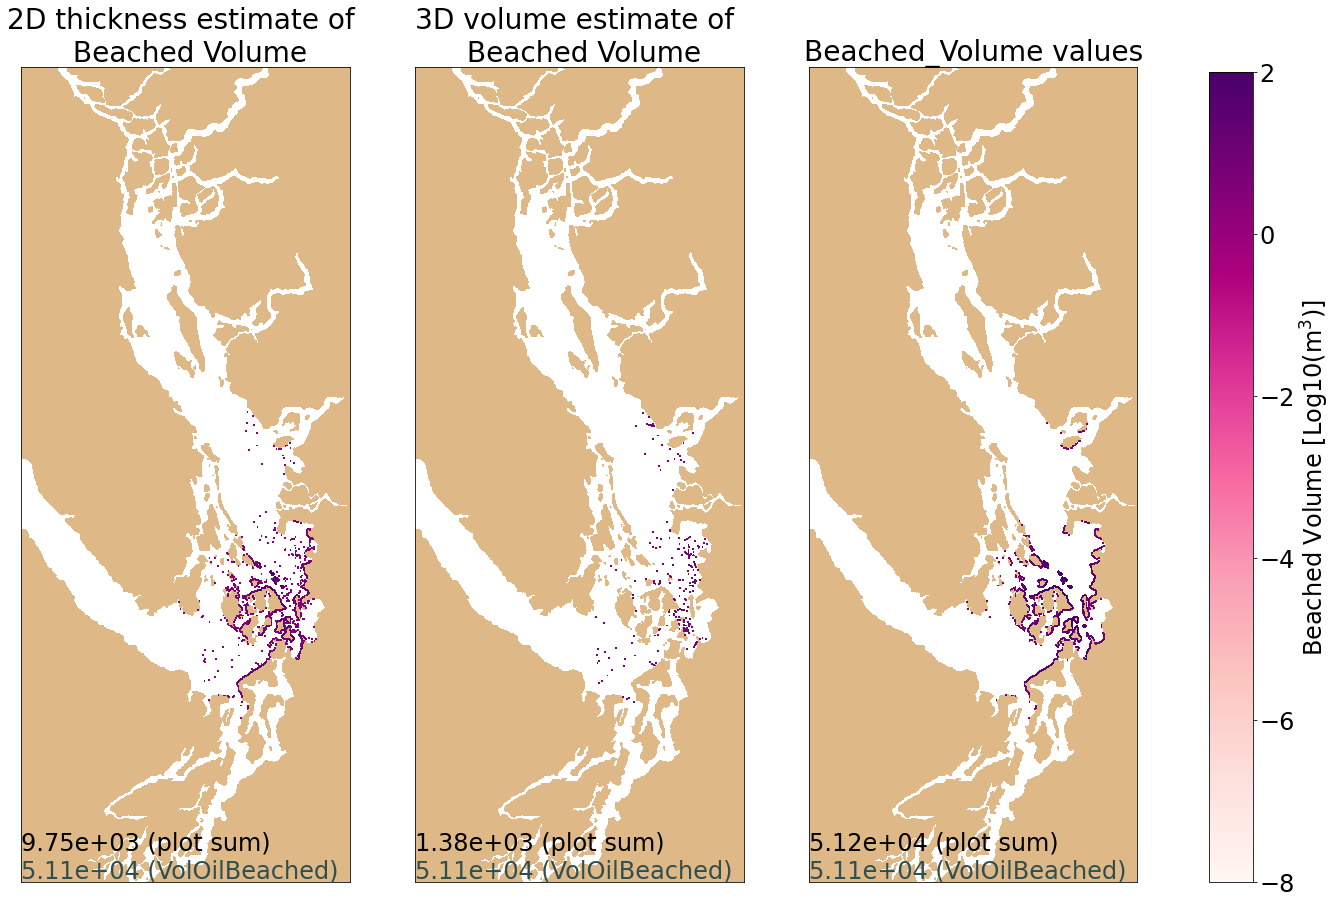

In [8]:
plot_vars = ['thickness','vol_3D','beaching_volume']
fig = plt.figure(figsize=(20,15))
ax = {}
ax[1] = fig.add_subplot(131)
ax[2] = fig.add_subplot(132) 
ax[3] = fig.add_subplot(133) 
for i in [1,2,3]:
    viz_tools.plot_land_mask(
        ax[i],
        '/Users/rmueller/Projects/MIDOSS/MIDOSS-MOHID-grid/AfterNEMOBathy201702.nc', 
        color = 'burlywood'
    )
    mappable = ax[i].pcolormesh(
        np.log10(beachingvolume[plot_vars[i-1]]),
        vmin = np.log10(1e-8),
        vmax = np.log10(1e2),
        cmap = 'RdPu'
    )
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    # add spill location with text in first panel
    ax[i].text(0.05, 35, 
        f'{np.nansum(beachingvolume[plot_vars[i-1]]):4.2e} (plot sum)', 
        fontsize = 24,
        color='black'
    )
    ax[i].text(0.05, 5, 
        f'{sro_results.VolOilBeached.values[-1]:4.2e} (VolOilBeached)', 
        fontsize = 24,
        color='darkslategrey'
    )

    if i==3:
        ax_cbar = fig.add_axes([.95, 0.125, 0.03, .75]) 
        cbar = plt.colorbar(
            mappable, 
            cax=ax_cbar, 
            orientation='vertical'
        )
        cbar.ax.tick_params(labelsize=24) 
        cbar.set_label('Beached Volume [Log10(m$^3$)]');

ax[1].set_title('2D thickness estimate of \n Beached Volume')
ax[2].set_title('3D volume estimate of \n Beached Volume')
ax[3].set_title('Beached_Volume values')


In [9]:
print('VolumeBeached:',sro_results.VolumeBeached.values[-1])
print('VolOilBeached:',sro_results.VolOilBeached.values[-1])
print('Volume:',sro_results.Volume.values[-1])
print('VolumeOil:',sro_results.VolumeOil.values[-1])

VolumeBeached: 69100.2519848
VolOilBeached: 51134.3972256
Volume: 10629.8161708
VolumeOil: 7866.06297161


### Take-away:
- `Beached_Volume` from the netcdf output gives the best estimate of the .sro values for `VolOilBeached` (as expected)
- `OilWaterColumnOilVol_3D` does not include land points
- `Thickness_2D` does include land points
- I used beaching time scale to select beached values for both 3D and 2D values, but the locations don't appear as identical. The difference here must be in the values of Thickness_2D vs. Vol_3d.  In theory, the locations ought to match, but they don't.  This brings up the issue of whether Thickness_2D is the best proxy of surface oiling.  If  Vol_3d is a better estimate then this difference suggests that we ought to use the surface level of `OilWaterColumnOilVol_3D` to estimate surface oiling. 

Text(0.5, 1.0, 'Beached_Volume - \n 2D thickness estimate')

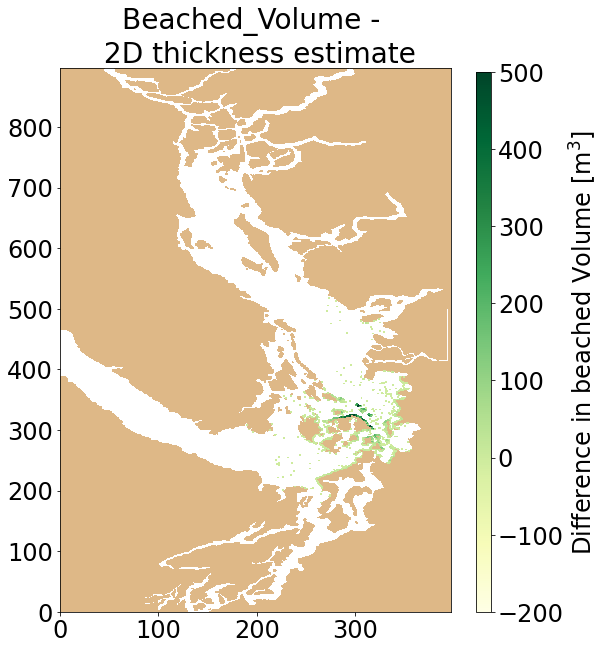

In [10]:
#diff = beachingvolume['thickness'] - beachingvolume['beaching_volume']
fig = plt.figure(figsize=(7,10))
ax = fig.add_subplot(1,1,1)
viz_tools.plot_land_mask(
    ax,
    '/Users/rmueller/Projects/MIDOSS/MIDOSS-MOHID-grid/AfterNEMOBathy201702.nc', 
    color = 'burlywood'
)
mappable = ax.pcolormesh(
    beachingvolume['beaching_volume'] - beachingvolume['thickness'],
    vmin = -200,
    vmax = 500,
    cmap = 'YlGn'
)
ax_cbar = fig.add_axes([.95, 0.125, 0.03, .75]) 
cbar = plt.colorbar(
    mappable, 
    cax=ax_cbar, 
    orientation='vertical'
)
cbar.ax.tick_params(labelsize=24) 
cbar.set_label('Difference in beached Volume [m$^3$]');

ax.set_title('Beached_Volume - \n 2D thickness estimate')

##  Is there a way for us to use the value in 2D thickness at the location of 3D_Vol in order to get a thickness estimate at the right locations?  

## This section explores that question.

In [27]:
floating_thickness = results.Thickness_2D[nt-1,:,:].where(notkeepers).values

print('beached oil:', 
      f'(mean) {np.nanmean(beachingvolume["thickness"])}', 
      f'(min) {np.nanmin(beachingvolume["thickness"])}', 
      f'(max) {np.nanmax(beachingvolume["thickness"])}')

print('floating oil:', 
      f'(mean) {np.nanmean(floating_thickness)}', 
      f'(min) {np.nanmin(floating_thickness)}', 
      f'(max) {np.nanmax(floating_thickness)}')

beached oil: (mean) 9.58317776204523 (min) 2.65298 (max) 154.962302
floating oil: (mean) 0.008382158894694751 (min) 0.0 (max) 36.7331


In [32]:
floating_thickness.shape

(896, 396)

### take-away: 2D thickness is spatially variable.  We can't simply apply a value to locations with 3D volume. 

plot up to get a sense of "footprint"

<ipython-input-52-a3815e896884>:8: RuntimeWarning: divide by zero encountered in log10
  np.log10(floating_thickness),


[]

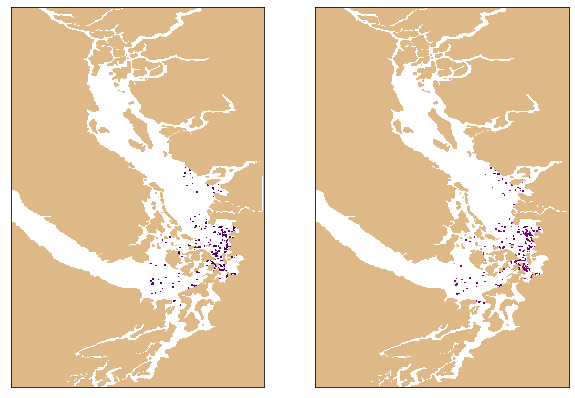

In [52]:
fig = plt.figure(figsize=(10,7))
ax = {}
ax[1] = fig.add_subplot(121)
ax[2] = fig.add_subplot(122)

# 2D thickness
mappable = ax[1].pcolormesh(
    np.log10(floating_thickness),
    vmin = np.log10(1e-10),
    vmax = np.log10(20),
    cmap = 'RdPu'
)
viz_tools.plot_land_mask(
    ax[1],
    '/Users/rmueller/Projects/MIDOSS/MIDOSS-MOHID-grid/AfterNEMOBathy201702.nc', 
    color = 'burlywood'
)
ax[1].set_xticks([])
ax[1].set_yticks([])

# 3D volume 

mappable = ax[2].pcolormesh(
    np.log10(results['OilWaterColumnOilVol_3D'][nt-1,39,:,:]),
    vmin = np.log10(1e-8),
    vmax = np.log10(1e2),
    cmap = 'RdPu'
)
viz_tools.plot_land_mask(
    ax[2],
    '/Users/rmueller/Projects/MIDOSS/MIDOSS-MOHID-grid/AfterNEMOBathy201702.nc', 
    color = 'burlywood'
)
ax[2].set_xticks([])
ax[2].set_yticks([])

### I expected a more coherent grouping of oil.  Testing values from earlier on in the run

<ipython-input-55-51e141ceea64>:10: RuntimeWarning: divide by zero encountered in log10
  np.log10(results.Thickness_2D[t_index,:,:].where(notkeepers).values),


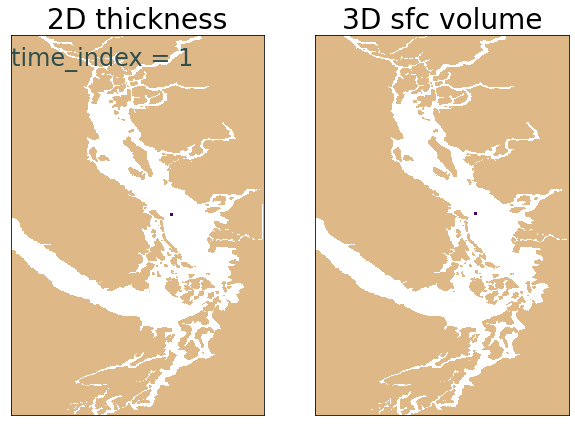

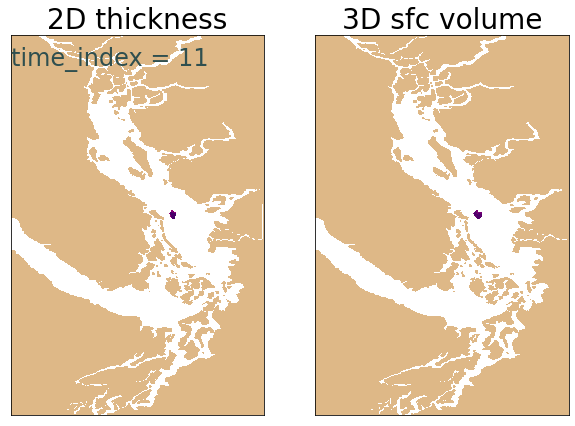

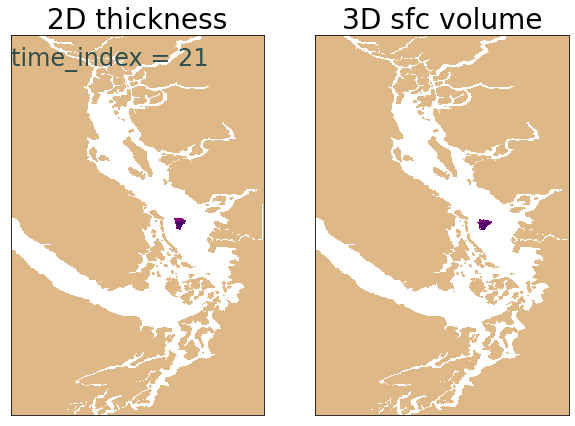

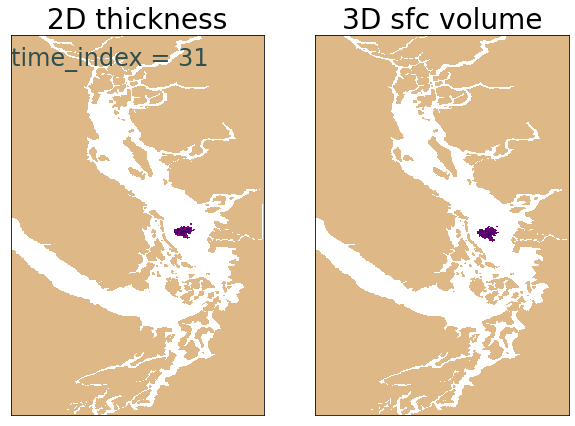

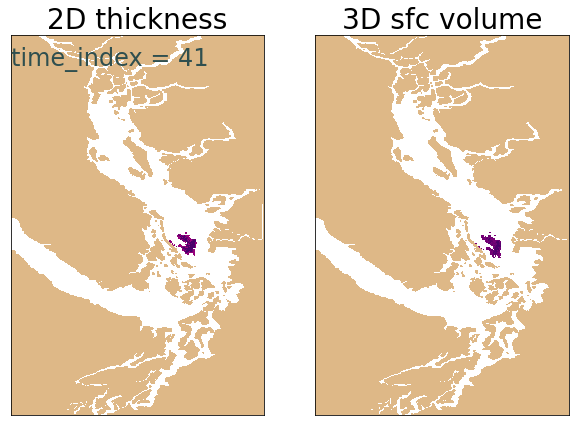

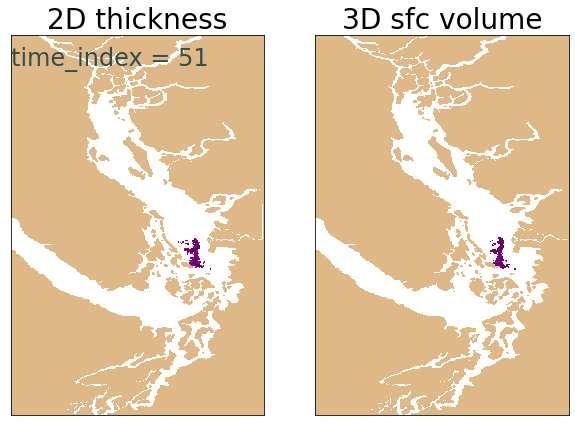

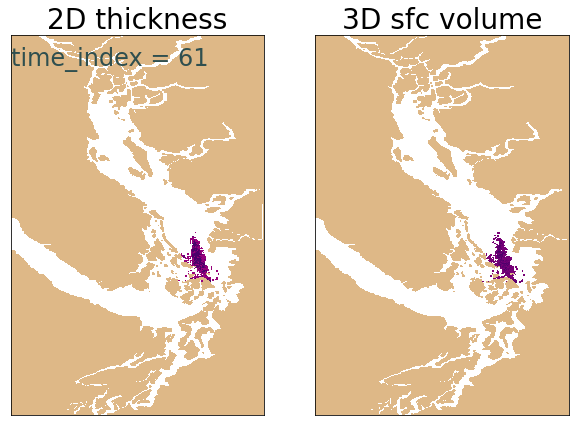

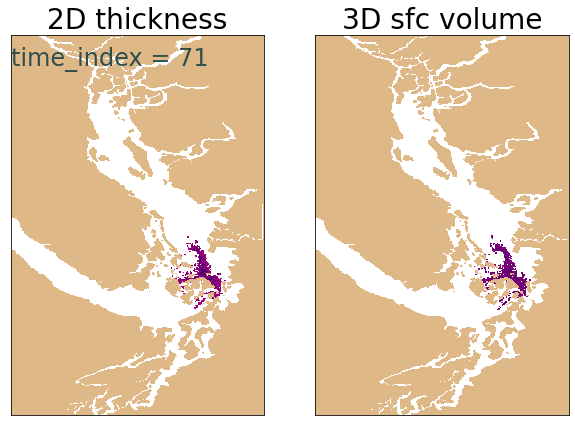

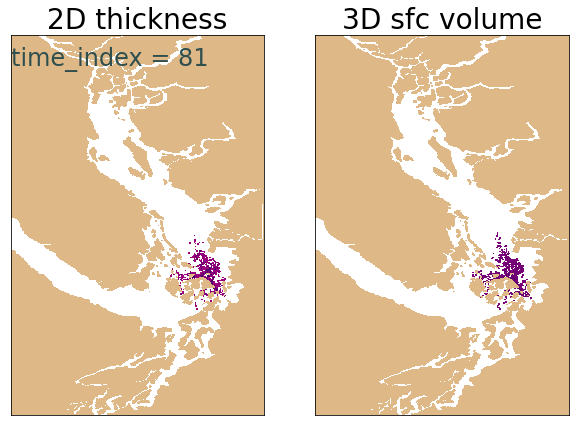

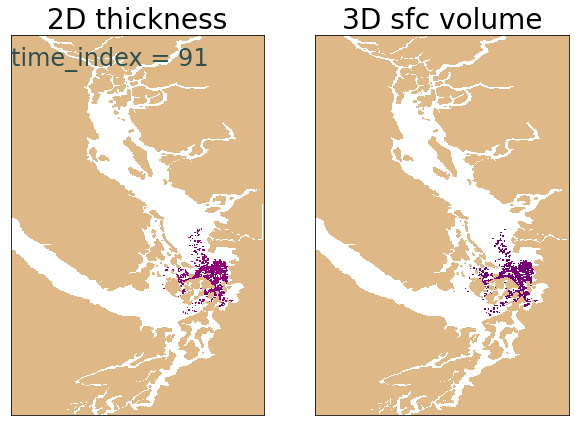

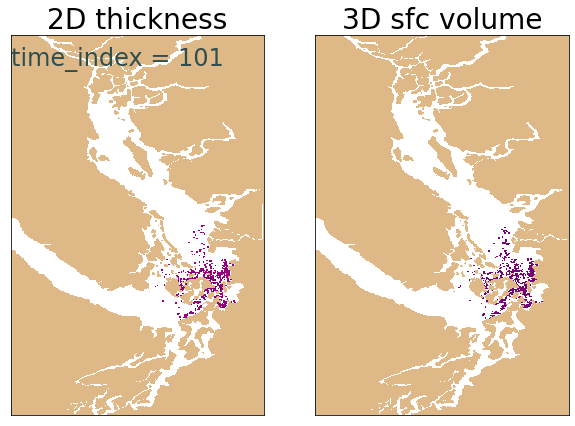

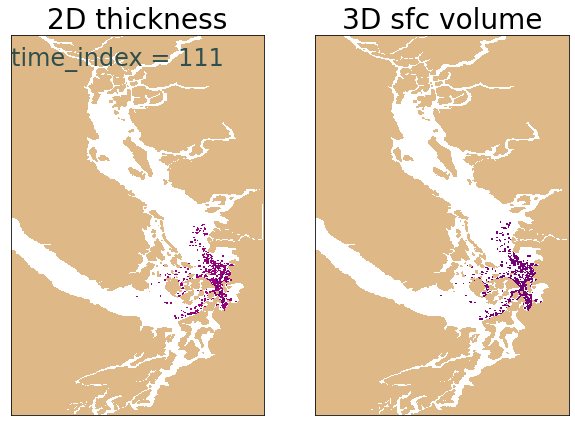

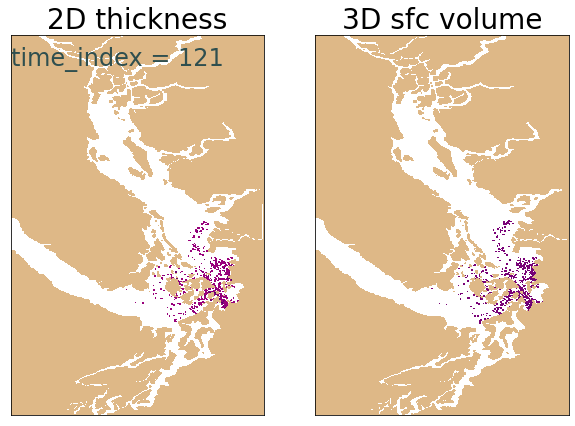

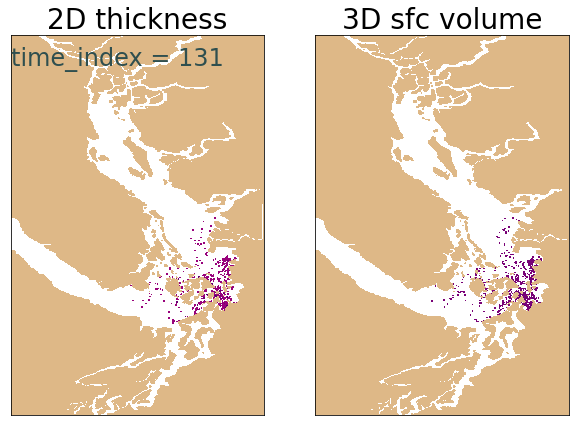

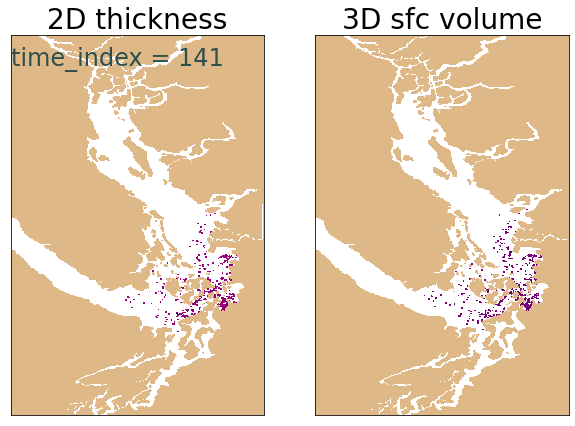

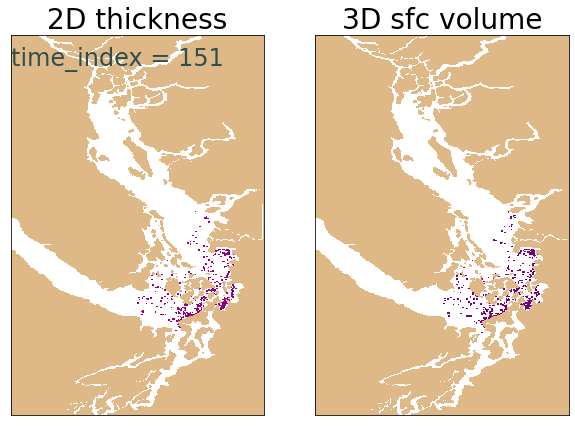

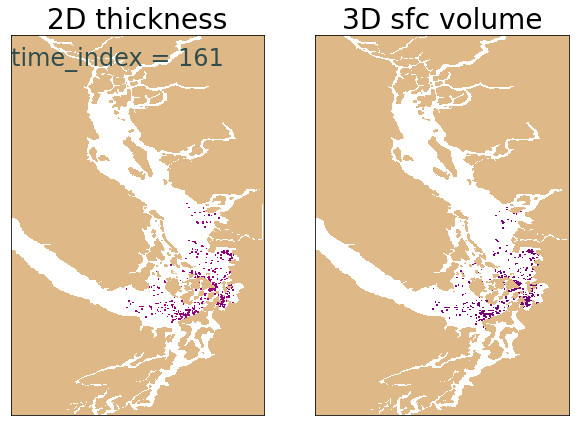

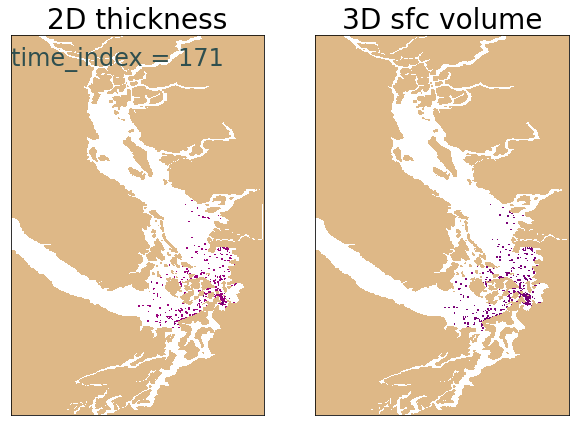

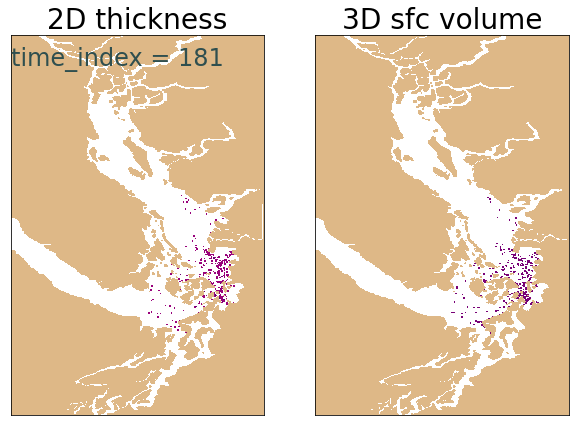

In [55]:
for t_index in np.arange(1,190,10):
    
    fig = plt.figure(figsize=(10,7))
    ax = {}
    ax[1] = fig.add_subplot(121)
    ax[2] = fig.add_subplot(122)

    # 2D thickness
    mappable = ax[1].pcolormesh(
        np.log10(results.Thickness_2D[t_index,:,:].where(notkeepers).values),
        vmin = np.log10(0.1),
        vmax = np.log10(40),
        cmap = 'RdPu'
    )
    viz_tools.plot_land_mask(
        ax[1],
        '/Users/rmueller/Projects/MIDOSS/MIDOSS-MOHID-grid/AfterNEMOBathy201702.nc', 
        color = 'burlywood'
    )
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_title('2D thickness')
    ax[1].text(0.05, 825, 
        f'time_index = {t_index}', 
        fontsize = 24,
        color='darkslategrey'
    )

    # 3D volume 

    mappable = ax[2].pcolormesh(
        np.log10(results['OilWaterColumnOilVol_3D'][t_index,39,:,:]),
        vmin = np.log10(1e-8),
        vmax = np.log10(1e2),
        cmap = 'RdPu'
    )
    viz_tools.plot_land_mask(
        ax[2],
        '/Users/rmueller/Projects/MIDOSS/MIDOSS-MOHID-grid/AfterNEMOBathy201702.nc', 
        color = 'burlywood'
    )
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    ax[2].set_title('3D sfc volume')
    
    

In [41]:
results.Thickness_2D.shape

(191, 896, 396)

In [45]:
test = range(1,10,191)
test

range(1, 10, 191)